# Open Weight VLMs  for Counting objects
In this notebook we use open weight LLMs with vision capabilities to see how well they can count blobs in blobs.tif .

Note: It is not recommended to use this approach for counting objects in microscopy images. The author of this notebook is not aware of any publication showing that this approach works well.

In [1]:
import openai
import PIL
import stackview
from skimage.io import imread
from skimage.measure import label
from skimage.segmentation import clear_border
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

We will need some helper functions for assembling a prompt and submitting it to the llm server.

In [2]:
def prompt_with_image(prompt:str, image, model="gemma3:4b", ollama_url="http://localhost:11434"):
    """A prompt helper function that sends a text message and an image
    to openAI and returns the text response.
    """
    import os
    
    if image is not None:
        message = image_to_message(image, prompt)
    else:
        message = [{"role": "user", "content": prompt}]

            
    # setup connection to the LLM
    client = openai.OpenAI(base_url=f"{ollama_url}/v1",)
    
    # submit prompt
    response = client.chat.completions.create(
        model=model,
        messages=message
    )
    
    # extract answer
    answer = response.choices[0].message.content
    if "</think>" in answer:
        answer = answer.split("</think>")[1].strip()
        
    return answer


def image_to_message(image, prompt):
    import base64

    from stackview._image_widget import _img_to_rgb

    rgb_image = _img_to_rgb(image)
    byte_stream = numpy_to_bytestream(rgb_image)
    base64_image = base64.b64encode(byte_stream).decode('utf-8')

    return [{"role": "user", "content": [
        {"type": "text", "text": prompt},
        {"type": "image_url",
        "image_url": {
            "url": f"data:image/jpeg;base64,{base64_image}"
        }

    }]}]


def numpy_to_bytestream(data):
    """Turn a NumPy array into a bytestream"""
    import numpy as np
    from PIL import Image
    import io

    # Convert the NumPy array to a PIL Image
    image = Image.fromarray(data.astype(np.uint8)).convert("RGBA")

    # Create a BytesIO object
    bytes_io = io.BytesIO()

    # Save the PIL image to the BytesIO object as a PNG
    image.save(bytes_io, format='PNG')

    # return the beginning of the file as a bytestream
    bytes_io.seek(0)
    return bytes_io.read()

[[[ 40  40  40]
  [ 32  32  32]
  [ 24  24  24]
  ...
  [216 216 216]
  [200 200 200]
  [200 200 200]]

 [[ 56  56  56]
  [ 40  40  40]
  [ 24  24  24]
  ...
  [232 232 232]
  [216 216 216]
  [216 216 216]]

 [[ 64  64  64]
  [ 48  48  48]
  [ 24  24  24]
  ...
  [240 240 240]
  [232 232 232]
  [232 232 232]]

 ...

 [[ 72  72  72]
  [ 80  80  80]
  [ 80  80  80]
  ...
  [ 48  48  48]
  [ 48  48  48]
  [ 48  48  48]]

 [[ 80  80  80]
  [ 80  80  80]
  [ 80  80  80]
  ...
  [ 48  48  48]
  [ 48  48  48]
  [ 48  48  48]]

 [[ 96  96  96]
  [ 88  88  88]
  [ 80  80  80]
  ...
  [ 48  48  48]
  [ 48  48  48]
  [ 48  48  48]]]
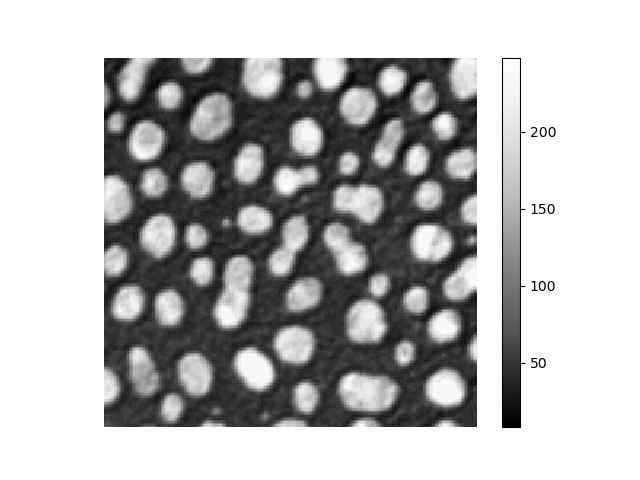
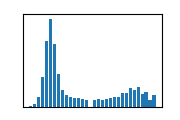

In [3]:
image = imread("data/blobs.tif")
image = np.stack([image,image,image],axis=2)
stackview.insight(image)

[[0 0 0 ... 5 5 5]
 [0 0 0 ... 5 5 5]
 [0 0 0 ... 5 5 5]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
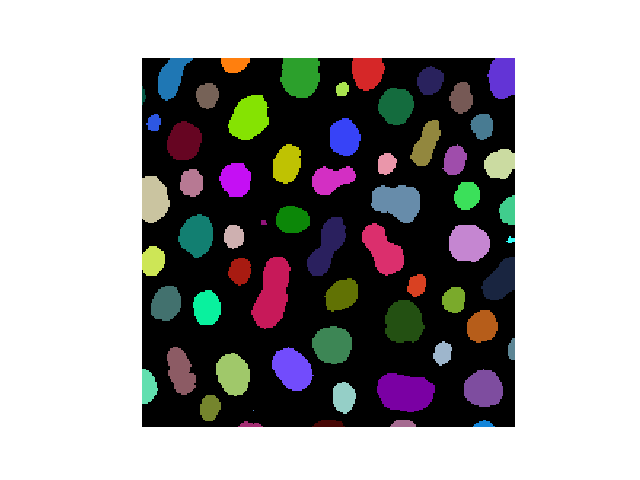

In [4]:
labels = label(image[...,0] > 128)

stackview.insight(labels)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
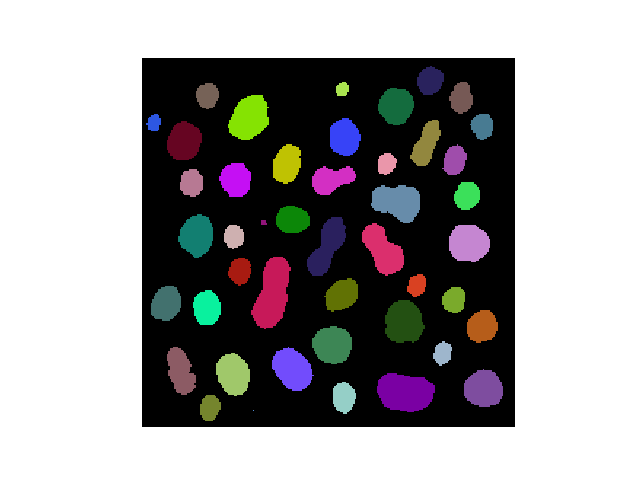

In [5]:
labels_wo_border = clear_border(labels)

stackview.insight(labels_wo_border)

This is the prompt we submit to the server.

In [6]:
my_prompt = """
Analyse the following image by counting the bright blobs. If you think you're not able to do this, try anyway. Respond with the number only.
"""

prompt_with_image(my_prompt, image=image, model="gemma3:4b")

'87'

## Benchmarking vision-LLMs
We can run this prompt in a loop for a couple of vision models.

In [7]:
num_samples = 25

models = {
    "gemma3:4b":[],    
    "gemma3:12b":[],
}
for model in tqdm(models.keys()):
    samples = []

    while len(samples) < num_samples:
        result = prompt_with_image(my_prompt, image=image, model=model).strip()
        if result.endswith("."):
            result = result[:-1]

        try:
            samples.append(int(result))
        except:
            print("Error processing result:", result)
            samples.append(np.nan)
    
    models[model] = samples

sampled_models = pd.DataFrame(models)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:27<00:00, 73.77s/it]


Let's get an overview about samples:

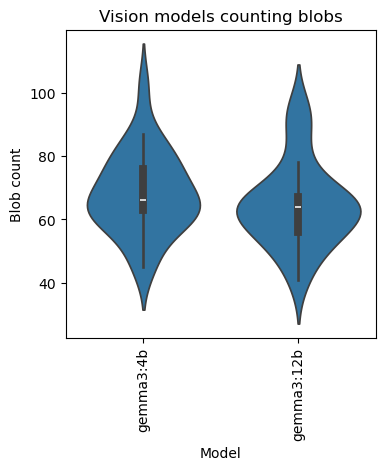

In [14]:
# Extract the two columns for comparison
columns_to_plot = sampled_models[models.keys()]

# Melt the dataframe to prepare for plotting
df_melted = columns_to_plot.melt(var_name='Model', value_name='Blob count')

# Draw the violin plot
plt.figure(figsize=(4, 4))
sns.violinplot(x='Model', y='Blob count', data=df_melted)

plt.title('Vision models counting blobs')
#plt.ylim(0, 150)  # Set the y-axis limits
plt.xticks(rotation=90)  # Rotate the x-axis labels
plt.show()

These are the results in detail:

In [9]:
sampled_models

,gemma3:4b,gemma3:12b
0,63,62
1,74,65
2,45,66
3,76,56
4,63,67
5,63,57
6,73,64
7,67,53
8,84,55
9,58,64


In [10]:
sampled_models.describe()

,gemma3:4b,gemma3:12b
count,25.000000,25.000000
mean,68.280000,64.600000
std,12.846919,13.235054
min,45.000000,41.000000
25%,63.000000,56.000000
50%,66.000000,64.000000
75%,76.000000,67.000000
max,102.000000,95.000000


In [11]:
sampled_models.to_csv("blob_count_by_vlms.csv")